(**You can also open this notebook in Google Colab**)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/data-programming-with-python/blob/main/2023-fall/2023-10-31/notebook/code_demo.ipynb)

# Regression Analysis - Linear Regression

Suppose you want to know **if money makes people happy**, so you download the Better Life Index data from the OECD’s website and stats about gross domestic product (GDP) per capita from the IMF’s website.
* OECD: https://www.oecdbetterlifeindex.org/
* IMF: https://ourworldindata.org/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_rows=None
pd.options.display.max_columns=None

## Get the data

In [3]:
oecd_bli = pd.read_csv('../data/oecd-better-life-index.csv',sep=',',header=0)
gdp_per_capita = pd.read_csv('../data/imf-gdp-per-capita.csv',sep=',',header=0,thousands=',')

In [4]:
oecd_bli.head(3)

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.4,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.5,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.7,NaN,NaN


In [5]:
gdp_per_capita.head(3)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.380,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.140,2014.0


## Transform the data

Get the view of 

| Country | GDP per capita (USD) | Life satisfaction |
|---------|----------------------|-------------------|

### format the oecd data

In [6]:
oecd_bli.Indicator.unique()

array(['Labour market insecurity',
       'Stakeholder engagement for developing regulations',
       'Dwellings without basic facilities', 'Housing expenditure',
       'Feeling safe walking alone at night', 'Rooms per person',
       'Household net adjusted disposable income', 'Household net wealth',
       'Employment rate', 'Long-term unemployment rate',
       'Personal earnings', 'Quality of support network',
       'Educational attainment', 'Student skills', 'Years in education',
       'Air pollution', 'Water quality', 'Voter turnout',
       'Life expectancy', 'Self-reported health', 'Life satisfaction',
       'Homicide rate', 'Employees working very long hours',
       'Time devoted to leisure and personal care'], dtype=object)

In [7]:
oecd_bli.Inequality.unique()

array(['Total', 'Men', 'Women', 'High', 'Low'], dtype=object)

In [8]:
oecd_bli2 = oecd_bli.loc[
    (oecd_bli.Inequality=='Total')&(oecd_bli.Indicator=='Life satisfaction'),
    ['Country','Value']
].rename(columns={'Country':'country','Value':'life_satisfaction'})

In [9]:
oecd_bli2.head(3)

,country,life_satisfaction
1813,Australia,7.3
1814,Austria,7.1
1815,Belgium,6.9


In [10]:
oecd_bli2.tail(3)

,country,life_satisfaction
1851,OECD - Total,6.5
2349,Colombia,6.3
2350,Lithuania,5.9


In [11]:
oecd_bli2.country.nunique()

41

### format the gdp per capita data

In [12]:
gdp_per_capita.Units.unique()

array(['U.S. dollars'], dtype=object)

In [13]:
gdp_per_capita2 = gdp_per_capita.loc[:,['Country','2015']].rename(columns={
    'Country':'country',
    '2015':'gdp_per_capita'
})
gdp_per_capita2.head(3)

,country,gdp_per_capita
0,Afghanistan,599.994
1,Albania,3995.380
2,Algeria,4318.140


In [14]:
gdp_per_capita2.country.nunique()

189

### join the two

In [15]:
country_stats = pd.merge(
    gdp_per_capita2,
    oecd_bli2,
    on='country'
).sort_values(by='gdp_per_capita').reset_index(drop=True)

In [16]:
country_stats.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
2,Brazil,8670.00,6.4


In [17]:
country_stats.tail(3)

,country,gdp_per_capita,life_satisfaction
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [18]:
country_stats.shape

(40, 3)

In [19]:
country_stats.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
2,Brazil,8670.00,6.4


In [20]:
country_stats[['gdp_per_capita', 'life_satisfaction']].corr()

,gdp_per_capita,life_satisfaction
gdp_per_capita,1.000000,0.720523
life_satisfaction,0.720523,1.000000


## split the data

In [21]:
# remove_indices = [2,3,8,12,37,38,39]
# keep_indices = list(set(range(40)) - set(remove_indices))

countries_remove = ['Brazil','Mexico','Chile','Czech Republic','Norway','Switzerland','Luxembourg']
countries_keep = set(country_stats.country) - set(countries_remove)

In [22]:
# sample_data = country_stats.iloc[keep_indices]
# missing_data = country_stats.iloc[remove_indices]
sample_data = country_stats[country_stats.country.isin(countries_keep)]
missing_data = country_stats[country_stats.country.isin(countries_remove)]

In [23]:
missing_data

,country,gdp_per_capita,life_satisfaction
2,Brazil,8670.00,6.4
3,Mexico,9009.28,6.5
8,Chile,13340.91,6.5
12,Czech Republic,17256.92,6.7
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [24]:
sample_data.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
4,Russia,9054.91,5.8


## visualize the sample data

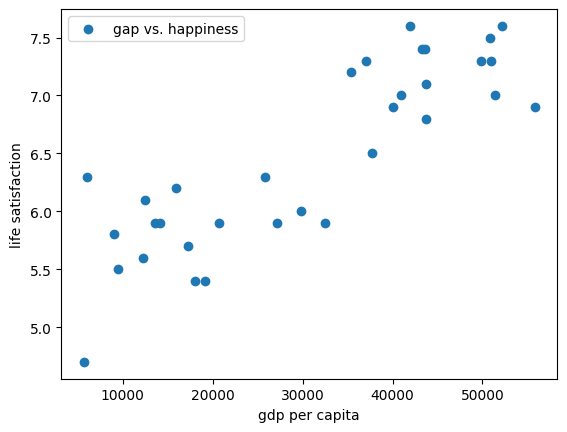

In [25]:
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction, label = 'gap vs. happiness')
plt.xlabel('gdp per capita')
plt.ylabel('life satisfaction')
plt.legend()

plt.show()

In [26]:
sample_data[sample_data.country.isin(['Hungary','Korea','France','Australia','United States'])]

,country,gdp_per_capita,life_satisfaction
6,Hungary,12239.89,5.6
18,Korea,27195.20,5.9
23,France,37675.01,6.5
33,Australia,50961.87,7.3
36,United States,55805.20,6.9


/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


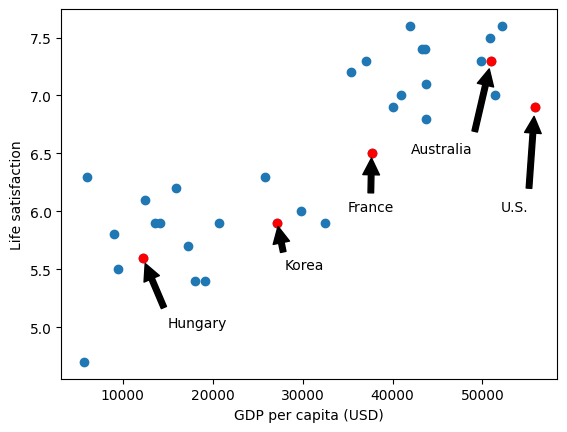

In [27]:
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction)
position_text = {
    "Hungary": (15000, 5),
    "Korea": (28000, 5.5),
    "France": (35000, 6.0),
    "Australia": (42000, 6.5),
    "United States": (52000, 6.0),
}

for country, pos_text in position_text.items():
    pos_data_x = sample_data.loc[sample_data.country==country,'gdp_per_capita']
    pos_data_y = sample_data.loc[sample_data.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.show()

There seems to be a linear trend here!!

## Fit a linear regression model!

Linear regression model
$$
y = \theta_0 + \theta_1X
$$

The fit essentially minimized the Sum of Squared Errors (SSE)
$$
SSE = \sum_{i=1}^{N} (y_i - \hat{y_i})^2 = \sum_{i=1}^{N} (y_i - \theta_0 - \theta_1X_i)^2
$$
Or, in the matrix form
$$
SSE = ||y - Xw||^2
$$

![](https://nextjournal.com/data/QmfPuPp4V74FyvTTojMj6ix9T8Skj1ji4GhX5Pr6zK8w4N?filename=linear-regression.png&content-type=image/png)

In [28]:
%%time

from sklearn import linear_model
lr = linear_model.LinearRegression()

# prepare the data
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]
# Xsample = sample_data.gdp_per_capita
# ysample = sample_data.life_satisfaction

# train the model
lr.fit(Xsample, ysample)

# get the model parameters
# t0, t1 = lr.intercept_[0], lr.coef_[0][0]
t0 = lr.intercept_[0]
t1 = lr.coef_[0][0]

t0, t1

CPU times: user 414 ms, sys: 92.9 ms, total: 507 ms
Wall time: 3.12 s


(5.166394143672077, 4.247060194254786e-05)

In [29]:
Xsample.ndim

2

In [30]:
Xsample.shape

(33, 1)

In [31]:
ysample.shape

(33, 1)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


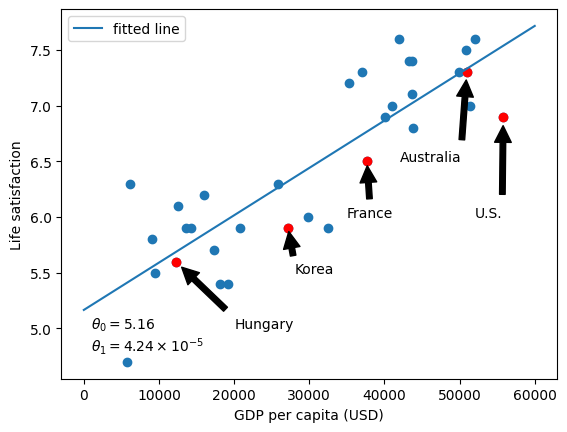

In [32]:
## same as previous plot
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction)
position_text = {
    "Hungary": (20000, 5),
    "Korea": (28000, 5.5),
    "France": (35000, 6.0),
    "Australia": (42000, 6.5),
    "United States": (52000, 6.0),
}

for country, pos_text in position_text.items():
    pos_data_x = sample_data.loc[sample_data.country==country,'gdp_per_capita']
    pos_data_y = sample_data.loc[sample_data.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

## plot the fitted line here
X = np.linspace(start=0, stop=60000, num=1000)
plt.plot(X, t1*X + t0, label='fitted line')
plt.text(1000, 5, '$\\theta_0=5.16$')
plt.text(1000, 4.8, '$\\theta_1=4.24 \\times 10^{-5}$')
    
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.show()

## Make predictions to a new country

In [33]:
gdp_per_capita2[gdp_per_capita2.country=='Cyprus']

,country,gdp_per_capita
42,Cyprus,22587.49


In [34]:
X_new = [[22587.49]]
lr.predict(X_new)

array([[6.12569844]])

In [35]:
gdp_per_capita2[gdp_per_capita2.country=='China']

,country,gdp_per_capita
34,China,7989.72


In [36]:
X_new = [[7989.72]]
lr.predict(X_new)

array([[5.50572236]])

## What happens when we add the missing countries back to the data?

In [37]:
missing_data

,country,gdp_per_capita,life_satisfaction
2,Brazil,8670.00,6.4
3,Mexico,9009.28,6.5
8,Chile,13340.91,6.5
12,Czech Republic,17256.92,6.7
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [38]:
%%time

lr2 = linear_model.LinearRegression()

# prepare the data
Xfull = np.c_[country_stats.gdp_per_capita]
yfull = np.c_[country_stats.life_satisfaction]

# train the model
lr2.fit(Xfull, yfull)

# get the model parameters
t0full, t1full = lr2.intercept_[0], lr2.coef_[0][0]
t0full, t1full

CPU times: user 1.77 ms, sys: 161 µs, total: 1.93 ms
Wall time: 1.96 ms


(5.72408173931895, 2.4690442763171645e-05)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


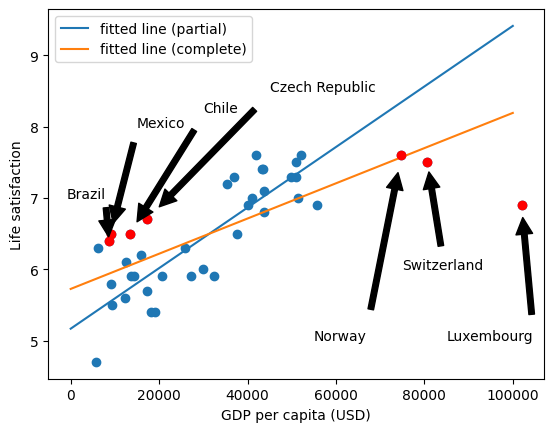

In [39]:
## same as previous plot
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

X = np.linspace(start=0, stop=100000, num=1000)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.show()

Apparently, the previous training data `sample_data` we used isn't representative!!

## Overfitting

In [40]:
## add polynomial features
from sklearn import preprocessing

df = 10
poly = preprocessing.PolynomialFeatures(degree=df)
scaler = preprocessing.StandardScaler()
lr3 = linear_model.LinearRegression()

Xfull_new = scaler.fit_transform(
    poly.fit_transform(Xfull)
)

## fit linear regression model on Xfull_new
lr3.fit(Xfull_new,yfull)

LinearRegression()

In [41]:
## define a set of new X
X = np.c_[np.linspace(start=0, stop=100000, num=1000)]

X_new = scaler.fit_transform(
    poly.fit_transform(X)
)

## predict on the new X
y = lr3.predict(X_new)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


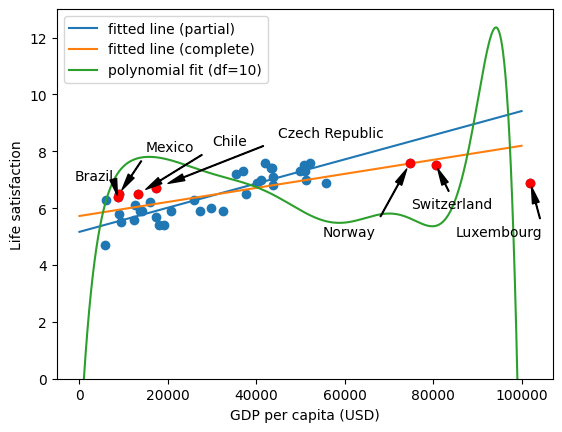

In [42]:
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

## plot the polynomial fit
plt.plot(X,y,label='polynomial fit (df={})'.format(df))
    
    
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.ylim(0,13)
plt.legend()
plt.show()

## Apply L2 Regularization (Ridge Regression)

Instead of minimizing
$$
SSE = ||y - Xw||^2
$$

We will minimize
$$
SSE = ||y - Xw||^2 + \alpha ||w||^2
$$

In the 2D situation

$$
SSE = ||y - Xw||^2 + \alpha ||w||^2 = \sum_{i=1}^{N} (y_i - \theta_0 - \theta_1X_i)^2 + \alpha (\theta_0^2 + \theta_1^2)
$$

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
* There is another kind of regularization called `L1 Regularization` (also called `Lasso Regression`)
    * More details can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
    * Aur´elien G´eron `Hands-On Machine Learning with Scikit-Learn and TensorFlow` O’Reilly Media, 2022.
        * Chapter 4
    * Differences between `L1` and `L2` regularization
        * https://www.linkedin.com/pulse/intuitive-visual-explanation-differences-between-l1-l2-xiaoli-chen/
        * https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when

The amount of regularization to apply during learning can be controlled by a hyperparameter. A hyperparameter is a parameter of a learning algorithm (not of the model). As such, it is not affected by the learning algorithm itself; it must be set prior to training and remains constant during training. 

Here, the parameter $\alpha$ is a hyperparamter. If you set the regularization hyperparameter to a very large value, you will get an almost flat model (a slope close to zero); the learning algorithm will almost certainly not overfit the training data, but it will be less likely to find a good solution. Tuning hyperparameters is an important part of building a Machine Learning system

In [43]:
## apply regularization on the original fit on sample_data
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


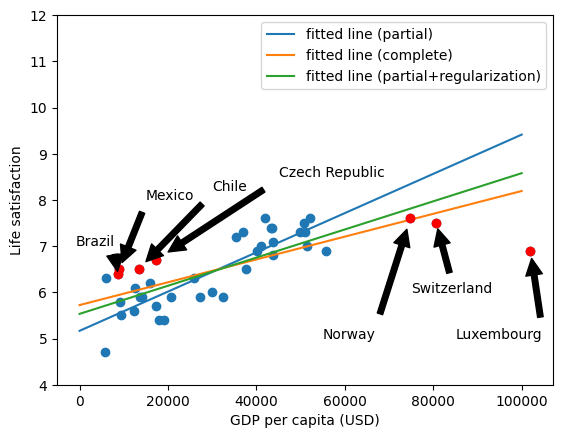

In [44]:
## same as previous plot
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

X = np.linspace(start=0, stop=100000, num=1000)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## plot the fitted line based on partial dataset with regularization
plt.plot(X, t1ridge*X + t0ridge, label='fitted line (partial+regularization)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.ylim(4,12)
plt.show()

### Vary the regularization parameter $\alpha$

In [45]:
alphas = [10**i for i in range(20)]

In [46]:
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]

In [47]:
%%time

from sklearn.metrics import mean_squared_error

rmses = []
r2s = []

for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(Xsample, ysample)
    ysample_predict = ridge.predict(Xsample)
    rmse = mean_squared_error(ysample, ysample_predict)
    r2 = ridge.score(Xsample,ysample)
    
    rmses.append(rmse)
    r2s.append(r2)

CPU times: user 51.2 ms, sys: 2.64 ms, total: 53.9 ms
Wall time: 63.1 ms


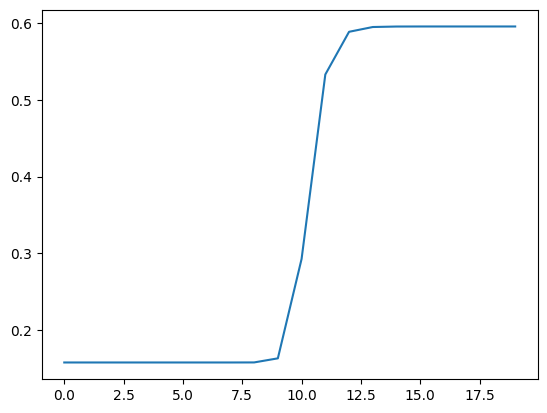

In [48]:
# plt.plot(alphas, rmses)
plt.plot(list(range(20)), rmses)
plt.show()

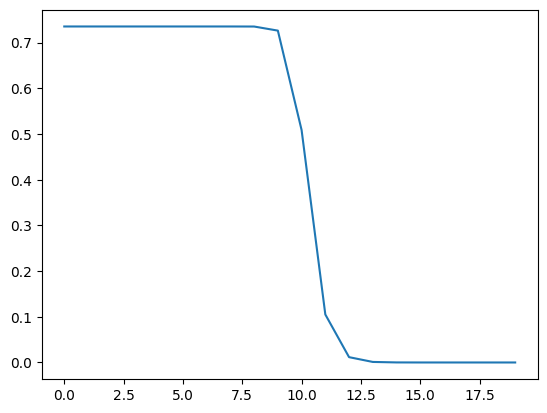

In [49]:
plt.plot(list(range(20)), r2s)
plt.show()

# Hands-On Example (continued)

The example is captured from the following book:
* Aur´elien G´eron *Hands-On Machine Learning with Scikit-Learn and TensorFlow* O’Reilly Media, 2019. (Chapter 2)

## Source
This dataset is a modified version of the California Housing dataset available from [Luís Torgo's page](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (University of Porto). Luís Torgo obtained it from the StatLib repository (which is closed now). The dataset may also be downloaded from StatLib mirrors.

This dataset appeared in a 1997 paper titled *Sparse Spatial Autoregressions* by Pace, R. Kelley and Ronald Barry, published in the *Statistics and Probability Letters* journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

## Tweaks
The dataset in this directory is almost identical to the original, with two differences:

* 207 values were randomly removed from the `total_bedrooms` column, so we can discuss what to do with missing data.
* An additional categorical attribute called `ocean_proximity` was added, indicating (very roughly) whether each block group is near the ocean, near the Bay area, inland or on an island. This allows discussing what to do with categorical data.

Note that the block groups are called "districts" in the Jupyter notebooks, simply because in some contexts the name "block group" was confusing.

## Define the problem to solve

### The big picture
* Goal: Build a model to predict median housing price of any given "district" based on the California census data
* Attributes you can expect in the dataset: population, median income, and median housing price for each block group



### Frame the problem

**Questions to ask first**

* How will the model fit into the bigger product plan
![](../pics/workflow-architecture.png)

* What's the current solution, if there is any?

**Frame the problem**

* Is it a supervised, unsupervised, semi-supervised, or reinforcement learning problem?
* Is it a regression problem, a classification problem, or something else?

**Find an appropriate performance measure**

* The RMSE (root mean squared error)
$$
RMSE(X,h) = \sqrt{ \frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)})-y^{(i)})^2 }
$$

![](https://nextjournal.com/data/QmfPuPp4V74FyvTTojMj6ix9T8Skj1ji4GhX5Pr6zK8w4N?filename=linear-regression.png&content-type=image/png)

* $R^2$
    * Reference: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
$$
R^2 = \frac{SS_{reg}}{SS_{Total}} = \frac{\sum_{i=1}^m(h(x^{(i)})-\bar{y})^2}{\sum_{i=1}^m(h(x^{(i)})-\bar{y})^2}= 1 - \frac{SS_{residual}}{SS_{Total}} = 1 - \frac{\sum_{i=1}^m(h(x^{(i)})-y^{(i)})^2}{\sum_{i=1}^m(h(x^{(i)})-\bar{y})^2}
$$

![](https://miro.medium.com/max/2812/1*o6okB-rex13szaQYNiHeKQ.png)

## Get the data, explore the data structure

### The data from high level

In [51]:
housing = pd.read_csv('../data/housing.csv',sep=',',header=0)
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [52]:
housing.shape

(20640, 10)

In [53]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


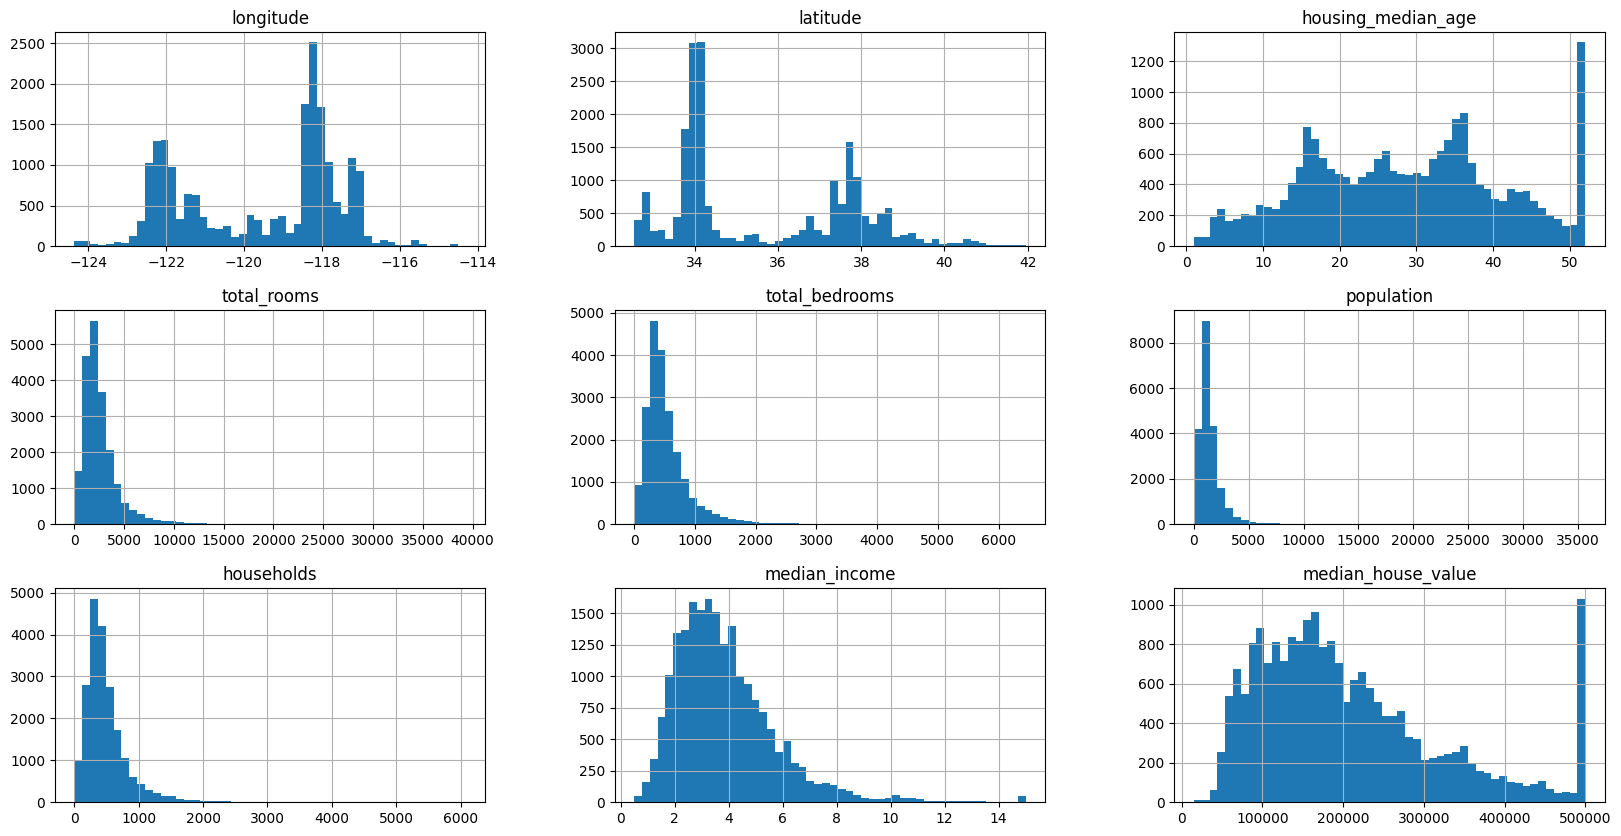

In [54]:
housing.hist(bins=50, figsize=(20,10))
plt.show()

In [55]:
df_proxy_stats = housing.ocean_proximity.value_counts().reset_index().rename(columns={'count':'rowcount'})
df_proxy_stats['pcnt'] = df_proxy_stats.rowcount/df_proxy_stats.rowcount.sum()
df_proxy_stats

,ocean_proximity,rowcount,pcnt
0,<1H OCEAN,9136,0.442636
1,INLAND,6551,0.317393
2,NEAR OCEAN,2658,0.128779
3,NEAR BAY,2290,0.110950
4,ISLAND,5,0.000242


### Correlation analysis

In [56]:
housing.select_dtypes(include=np.number).corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


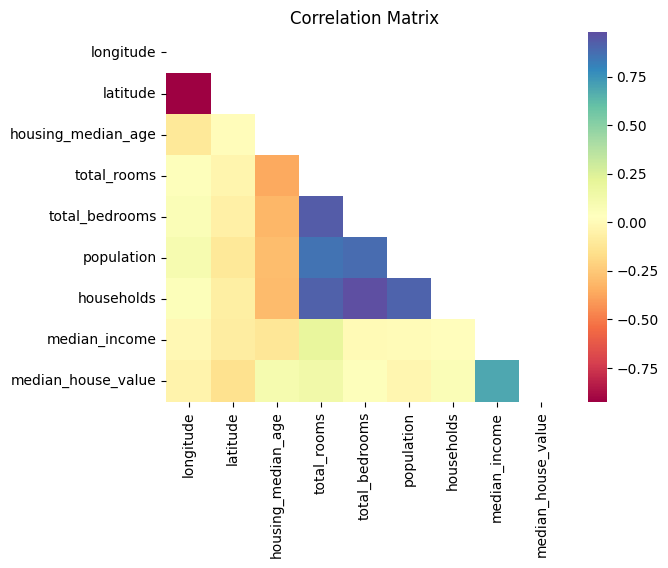

In [57]:
corrs = housing.select_dtypes(include=np.number).corr()

# we can also create a map to cover half of the matrix
mask = np.zeros_like(corrs)
# find the indices of the upper triangle of the given matrix
## https://numpy.org/doc/stable/reference/generated/numpy.triu_indices_from.html
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrs, cmap='Spectral', mask=mask)
plt.title('Correlation Matrix')
plt.show()

<span style="color:red">
Be careful on the multi-colinearities here!!!
</span>

## train-test split

### Pure random sampling

In [58]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=123
)


In [59]:
train_set.shape

(16512, 10)

In [60]:
test_set.shape

(4128, 10)

**Is this sampling good enough??**

### Keep an eye on the `median_income` column

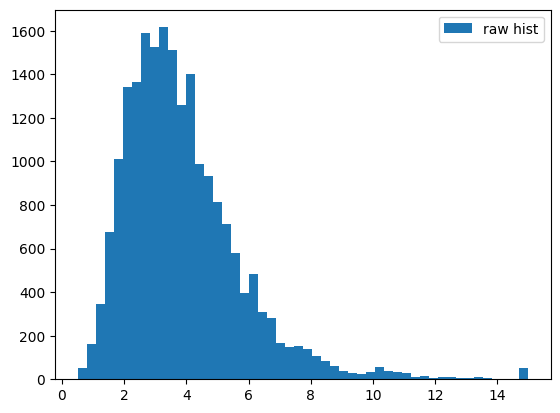

In [61]:
plt.hist(housing.median_income,bins=50,label='raw hist')
plt.legend()
plt.show()

In [62]:
## check the cdf of the median_income distribution
df_cdf_median_income = housing.median_income.sort_values(ascending=True).reset_index()
df_cdf_median_income['cum_freq'] = np.arange(1,len(df_cdf_median_income)+1)
df_cdf_median_income['cum_prob'] = df_cdf_median_income['cum_freq']/df_cdf_median_income['cum_freq'].shape[0]
df_cdf_median_income.drop(columns=['index'],inplace=True)

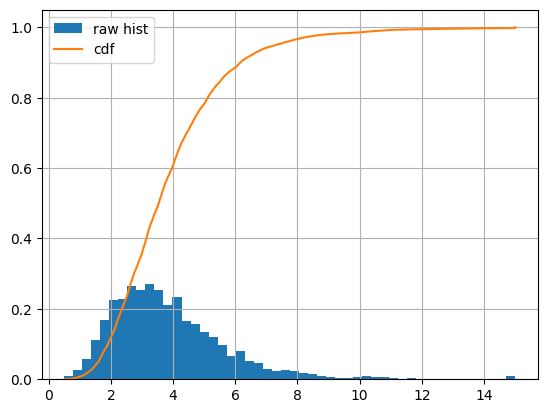

In [63]:
plt.hist(housing.median_income,bins=50,label='raw hist',density=True)
plt.plot(df_cdf_median_income.median_income,df_cdf_median_income.cum_prob,label='cdf')
plt.legend()
plt.grid()
plt.show()

**Some further grouping**

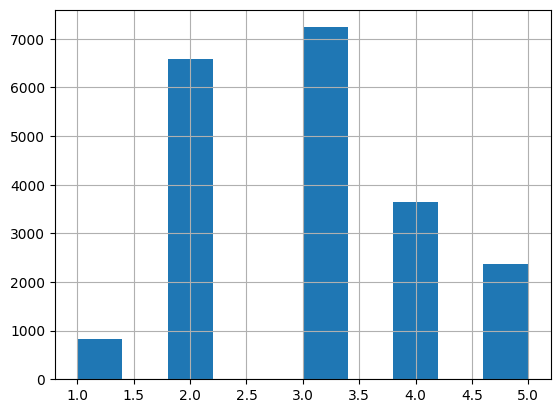

In [64]:
housing['income_cat'] = pd.cut(
    x = housing['median_income'],
    bins = [0,1.5,3.0,4.5,6, np.inf],
    labels = [1,2,3,4,5]
)

plt.hist(housing.income_cat)
plt.grid()
plt.show()

In [65]:
housing.income_cat.value_counts().reset_index()

,income_cat,count
0,3,7236
1,2,6581
2,4,3639
3,5,2362
4,1,822


### Stratified sampling on `median_income`

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [67]:
## let's compare the median_income distribution via the two random splitting methodologies

train_set, test_set = train_test_split(
    housing, test_size=0.2, random_state=123
)

compare_props = pd.DataFrame({
    "Overall": housing.income_cat.value_counts()/housing.shape[0],
    "Stratified": strat_test_set["income_cat"].value_counts()/len(strat_test_set),
    "Random": test_set["income_cat"].value_counts()/len(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"]/compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"]/compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.038760,-2.676399,0.364964
2,0.318847,0.318798,0.313227,-1.762650,-0.015195
3,0.350581,0.350533,0.360465,2.819237,-0.013820
4,0.176308,0.176357,0.178779,1.401484,0.027480
5,0.114438,0.114341,0.108769,-4.953429,-0.084674


In [68]:
### A easier way to do stratified sampling

strat_train_set2, strat_test_set2 = train_test_split(
    housing, test_size=0.2, random_state=123, stratify=housing['income_cat']
)

compare_props = pd.DataFrame({
    "Overall": housing.income_cat.value_counts()/housing.shape[0],
    "Stratified": strat_test_set["income_cat"].value_counts()/len(strat_test_set),
    "Stratified2": strat_test_set2["income_cat"].value_counts()/len(strat_test_set2),
    "Random": test_set["income_cat"].value_counts()/len(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"]/compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"]/compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Stratified2,Random,Rand. %error,Strat. %error
income_cat,,,,,,
1,0.039826,0.039971,0.039971,0.038760,-2.676399,0.364964
2,0.318847,0.318798,0.318798,0.313227,-1.762650,-0.015195
3,0.350581,0.350533,0.350533,0.360465,2.819237,-0.013820
4,0.176308,0.176357,0.176357,0.178779,1.401484,0.027480
5,0.114438,0.114341,0.114341,0.108769,-4.953429,-0.084674


### finalize the train-test split

In [69]:
strat_train_set.drop(columns=['income_cat'],inplace=True)
strat_test_set.drop(columns=['income_cat'],inplace=True)

## More visualization on the data

### housing price by geo location

In [70]:
housing2 = strat_train_set.copy()

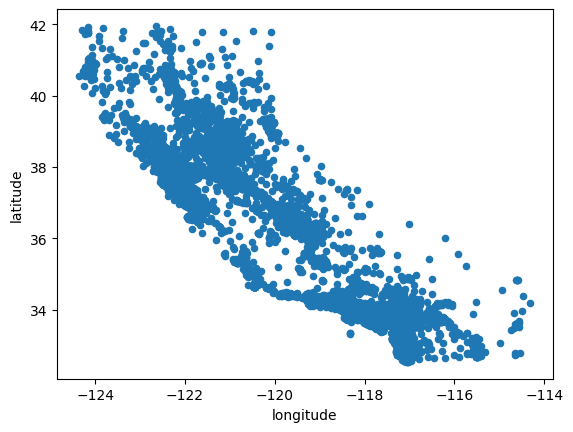

In [71]:
housing2.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

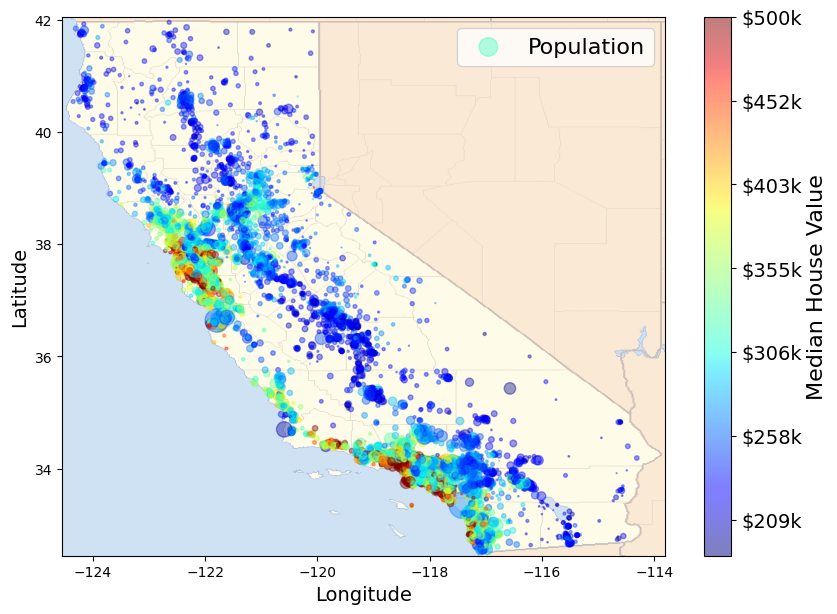

In [72]:
## make the map visualization even fancier

import matplotlib.image as mpimg
california_img=mpimg.imread('../pics/california.png')
ax = housing2.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing2['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing2["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()


### revisit the correlation analysis

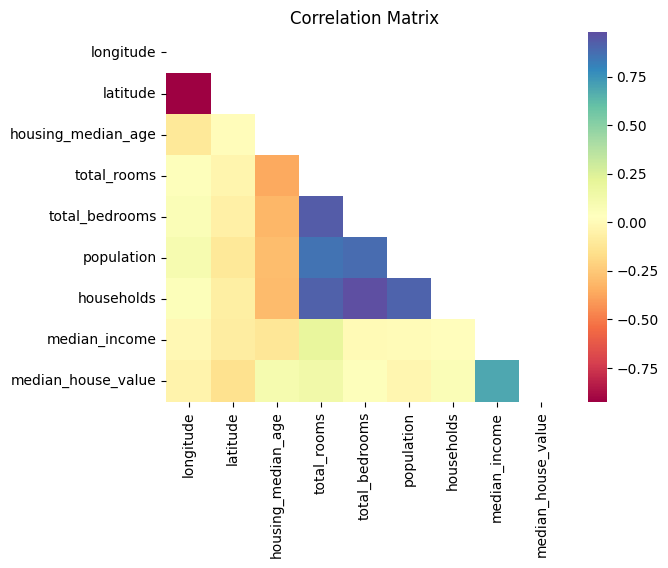

In [73]:
corr_matrix = housing2.select_dtypes(include=np.number).corr()

# we can also create a map to cover half of the matrix
mask = np.zeros_like(corr_matrix)
# find the indices of the upper triangle of the given matrix
## https://numpy.org/doc/stable/reference/generated/numpy.triu_indices_from.html
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrs, cmap='Spectral', mask=mask)
plt.title('Correlation Matrix')
plt.show()

In [74]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688825
total_rooms           0.135388
housing_median_age    0.110918
households            0.067539
total_bedrooms        0.050226
population           -0.022426
longitude            -0.046091
latitude             -0.144711
Name: median_house_value, dtype: float64

**Observations**
* The most promising attribute to predict the `median_house_value` is the `median_income`.
* There are some multicolinearity present among `total_rooms`, `total_bedrooms`, `population`, and `households`

## Add more features

In [75]:
housing2["rooms_per_household"] = housing2["total_rooms"]/housing2["households"]
housing2["bedrooms_per_room"] = housing2["total_bedrooms"]/housing2["total_rooms"]
housing2["population_per_household"]=housing2["population"]/housing2["households"]

In [76]:
corr_matrix = housing2.select_dtypes(include=np.number).corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688825
rooms_per_household         0.145367
total_rooms                 0.135388
housing_median_age          0.110918
households                  0.067539
total_bedrooms              0.050226
population_per_household   -0.022016
population                 -0.022426
longitude                  -0.046091
latitude                   -0.144711
bedrooms_per_room          -0.259627
Name: median_house_value, dtype: float64

## Prepare the data for the model fitting

In [77]:
housing2 = strat_train_set.drop(columns='median_house_value') # the Xs
housing2_labels = strat_train_set['median_house_value'].copy() # the y

In [78]:
housing2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 20198 to 14678
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16350 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### fix the null value

In [79]:
housing2[housing2.total_bedrooms.isnull()].shape

(162, 9)

In [80]:
housing2.shape

(16512, 9)

1. Get rid of the corresponding districts.

2. Get rid of the whole attribute.

3. Set the values to some value (zero, the mean, the median, etc.).

```python
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

**test the option 3**

In [81]:
sample_incomplete_rows = housing2[housing2.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
11441,-117.98,33.73,18.0,3833.0,NaN,2192.0,996.0,3.4679,<1H OCEAN
10216,-117.91,33.87,29.0,1121.0,NaN,762.0,276.0,2.5000,<1H OCEAN
4447,-118.21,34.07,52.0,1770.0,NaN,1848.0,439.0,2.4135,<1H OCEAN


In [82]:
median = housing2["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,435.0,825.0,626.0,2.9330,NEAR BAY
13656,-117.30,34.05,6.0,2155.0,435.0,1039.0,391.0,1.6675,INLAND
11441,-117.98,33.73,18.0,3833.0,435.0,2192.0,996.0,3.4679,<1H OCEAN
10216,-117.91,33.87,29.0,1121.0,435.0,762.0,276.0,2.5000,<1H OCEAN
4447,-118.21,34.07,52.0,1770.0,435.0,1848.0,439.0,2.4135,<1H OCEAN


In [83]:
sample_incomplete_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1606 to 4447
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           5 non-null      float64
 1   latitude            5 non-null      float64
 2   housing_median_age  5 non-null      float64
 3   total_rooms         5 non-null      float64
 4   total_bedrooms      5 non-null      float64
 5   population          5 non-null      float64
 6   households          5 non-null      float64
 7   median_income       5 non-null      float64
 8   ocean_proximity     5 non-null      object 
dtypes: float64(8), object(1)
memory usage: 400.0+ bytes


**The `scikit-learn` way to implement option 3**
* reference: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [84]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # transformer

In [85]:
## Only the total_bedrooms attribute had missing values
## but we cannot be sure that there won’t be any missing values in new data after the system goes live
housing_num = housing2.drop(columns='ocean_proximity')
imputer.fit(housing_num)

SimpleImputer(strategy='median')

**Further breakdown of the parameters**

In [86]:
imputer.strategy

'median'

In [87]:
## The imputation fill value for each feature
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2127.5   ,  435.    , 1165.    ,
        410.    ,    3.5391])

In [88]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2127.5   ,  435.    , 1165.    ,
        410.    ,    3.5391])

In [89]:
## apply the transformation
X = imputer.transform(housing_num)

In [90]:
type(X)

numpy.ndarray

In [91]:
X.shape

(16512, 8)

**The even simpler `scikit-learn` way**

In [92]:
imputer = SimpleImputer(strategy="median")
housing_num = housing2.drop(columns='ocean_proximity')
X = imputer.fit_transform(housing_num) # one-stop

In [93]:
X.shape

(16512, 8)

In [94]:
type(X)

numpy.ndarray

In [95]:
df_X = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
df_X.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20198,-119.19,34.26,16.0,5018.0,853.0,2524.0,830.0,5.1752
2092,-119.78,36.75,43.0,2070.0,512.0,1925.0,444.0,1.4635
16668,-120.69,35.25,15.0,4210.0,899.0,1933.0,867.0,2.7940


In [96]:
df_X.shape

(16512, 8)

In [97]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 20198 to 14678
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Encode the text and categorical attributes

In [98]:
housing2.ocean_proximity.value_counts().reset_index()

,ocean_proximity,count
0,<1H OCEAN,7306
1,INLAND,5249
2,NEAR OCEAN,2125
3,NEAR BAY,1829
4,ISLAND,3


* reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [99]:
## approach 1
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing2[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder() # transformer
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [1.],
       [4.],
       [0.],
       [0.],
       [3.],
       [0.],
       [1.],
       [3.],
       [0.]])

In [100]:
housing_cat[:10]

,ocean_proximity
20198,NEAR OCEAN
2092,INLAND
16668,NEAR OCEAN
10941,<1H OCEAN
17350,<1H OCEAN
15645,NEAR BAY
3889,<1H OCEAN
18987,INLAND
16005,NEAR BAY
3938,<1H OCEAN


In [101]:
type(housing_cat_encoded)

numpy.ndarray

In [102]:
pd.Series(housing_cat_encoded.flatten()).value_counts()

0.0    7306
1.0    5249
4.0    2125
3.0    1829
2.0       3
Name: count, dtype: int64

In [103]:
ordinal_encoder.categories_ # the order is aligned with the encoding values

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [104]:
## reconstruct the mapping

In [105]:
df_map_ordinalencoder = pd.DataFrame({
    'ocean_proximity': ordinal_encoder.categories_[0],
    'encoded_ocean_proximity': np.arange(housing2.ocean_proximity.nunique())
})
df_map_ordinalencoder

,ocean_proximity,encoded_ocean_proximity
0,<1H OCEAN,0
1,INLAND,1
2,ISLAND,2
3,NEAR BAY,3
4,NEAR OCEAN,4


In [106]:
## we could also customize the encoding order
housing_cat = housing2[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder(categories=[['INLAND','<1H OCEAN','ISLAND','NEAR BAY','NEAR OCEAN']])
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_

[array(['INLAND', '<1H OCEAN', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [107]:
pd.DataFrame({
    'ocean_proximity': ordinal_encoder.categories_[0],
    'encoded_ocean_proximity': np.arange(housing2.ocean_proximity.nunique())
})

,ocean_proximity,encoded_ocean_proximity
0,INLAND,0
1,<1H OCEAN,1
2,ISLAND,2
3,NEAR BAY,3
4,NEAR OCEAN,4


<span style="color:red">
The order reflected in the encoding values isn't aligned with the intrinsic mutual relations in the original categories
</span>

**The `OneHot` encoding**

![](https://i.imgur.com/mtimFxh.png)

$$
y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_mX_m + \beta_{m+1}D_{red} + \beta_{m+2}D_{yellow} + \beta_{m+3}D_{green}
$$

* The additional features created from `OneHot` encoding are also called `dummy variables`
* The encoding makes sure the phase space of all categories in a variable are orthogonal to each other
* As you can see, the above linear regression fitting only changes the intercept when changing the dummy variable values.
* You could make it even fancier just so you could also change the slope !!!

$$
y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_mX_m + \beta_{m+1}D_{red} + \beta_{m+2}D_{yellow} + \beta_{m+3}D_{green} + \beta_{m+1}D_{red}X_1 + \beta_{m+2}D_{yellow}X_2 + \beta_{m+3}D_{green}X_3
$$

* reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [108]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [109]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [110]:
housing_cat_1hot.toarray().shape

(16512, 5)

In [111]:
## if you prefer not to use the sparse matrix representation

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [112]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [113]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [114]:
## we could also validate the onehot encoding mapping
categories = cat_encoder.categories_[0]
categories

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [115]:
categories_df = pd.DataFrame(categories, columns=['ocean_proximity'])

In [116]:
one_hot_mapping = cat_encoder.transform(categories_df)

In [117]:
one_hot_mapping

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [118]:
onehot_comprison = np.c_[categories, one_hot_mapping]
df_onehot_comprison = pd.DataFrame(onehot_comprison, columns=['ocean_proximity','d1','d2','d3','d4','d5'])
df_onehot_comprison

,ocean_proximity,d1,d2,d3,d4,d5
0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
1,INLAND,0.0,1.0,0.0,0.0,0.0
2,ISLAND,0.0,0.0,1.0,0.0,0.0
3,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0


### Recap all the transformations covered

In [119]:
housing2.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20198,-119.19,34.26,16.0,5018.0,853.0,2524.0,830.0,5.1752,NEAR OCEAN
2092,-119.78,36.75,43.0,2070.0,512.0,1925.0,444.0,1.4635,INLAND
16668,-120.69,35.25,15.0,4210.0,899.0,1933.0,867.0,2.7940,NEAR OCEAN


**Recap on the data transformations we tried so far**
* Fix missing values in numeric columns/features (with median values)
* `OneHot` encode categorical variables `ocean_proximity`
* Add additional features: 
    * `rooms_per_household`
    * `bedrooms_per_room`
    * `population_per_household`
* Feature scaling (<span style="color:red">To Do</span>)

### All transformations in One Step

In [120]:
## split X and y
housing2 = strat_train_set.drop(columns='median_house_value')
housing2_labels = strat_train_set['median_house_value'].copy()
## split numeric and categorical variables
housing_num = housing2.drop(columns='ocean_proximity')
housing_cat = housing2[['ocean_proximity']]

## fill missing values in numeric features
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy="median") # transformer 1
X_num = num_imputer.fit_transform(housing_num)

## onehot encode ocean_proximity
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False) # transformer 2
X_cat = cat_encoder.fit_transform(housing_cat)

## create new features
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
rooms_per_household = X_num[:, rooms_ix] / X_num[:, households_ix]
population_per_household = X_num[:, population_ix] / X_num[:, households_ix]
bedrooms_per_room = X_num[:, bedrooms_ix] / X_num[:, rooms_ix]

## append the new features to X_num
X_num = np.c_[
    X_num,
    rooms_per_household,
    population_per_household,
    bedrooms_per_room
]

## feature scaling
from sklearn.preprocessing import StandardScaler
num_scaler = StandardScaler() # transformer 3
X_num = num_scaler.fit_transform(X_num)

## combine numeric and categorical features
housing2_prepared = np.c_[X_num, X_cat]

In [121]:
X_num.shape

(16512, 11)

In [122]:
X_cat.shape

(16512, 5)

In [123]:
housing2_prepared.shape

(16512, 16)

* A lot of coding here!!!

### Try the `pipeline` function in `sklearn`

![](https://iaml.it/blog/optimizing-sklearn-pipelines/images/pipeline-diagram.png)

* reference: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [124]:
## build a customized transformer to append new features

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class AppendNewFeatures(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]


In [125]:
## test the module

attr_adder = AppendNewFeatures()
housing_extra_attribs = attr_adder.transform(housing2.values)
housing_extra_attribs[:3]

array([[-119.19, 34.26, 16.0, 5018.0, 853.0, 2524.0, 830.0, 5.1752,
        'NEAR OCEAN', 6.04578313253012, 3.040963855421687,
        0.16998804304503787],
       [-119.78, 36.75, 43.0, 2070.0, 512.0, 1925.0, 444.0, 1.4635,
        'INLAND', 4.662162162162162, 4.335585585585585,
        0.24734299516908212],
       [-120.69, 35.25, 15.0, 4210.0, 899.0, 1933.0, 867.0, 2.794,
        'NEAR OCEAN', 4.855824682814302, 2.229527104959631,
        0.2135391923990499]], dtype=object)

Build a pipeline for preprocessing the numerical attributes

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AppendNewFeatures()),
        ('std_scaler', StandardScaler())
    ])

In [127]:
## test the pipeline
housing_num2 = num_pipeline.fit_transform(housing_num)
housing_num2.shape

(16512, 11)

We could also create one pipeline to handle both numeric and categorical variables

In [128]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [129]:
housing2.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20198,-119.19,34.26,16.0,5018.0,853.0,2524.0,830.0,5.1752,NEAR OCEAN
2092,-119.78,36.75,43.0,2070.0,512.0,1925.0,444.0,1.4635,INLAND
16668,-120.69,35.25,15.0,4210.0,899.0,1933.0,867.0,2.7940,NEAR OCEAN


In [130]:
housing2_prepared2 = full_pipeline.fit_transform(housing2)

In [131]:
housing2_prepared2.shape

(16512, 16)

In [132]:
housing2_prepared.shape

(16512, 16)

## Train a model

In [133]:
housing2_prepared = full_pipeline.fit_transform(housing2)

In [134]:
type(housing2_prepared)

numpy.ndarray

### Fit a linear regression model

In [135]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # predictor
lin_reg.fit(housing2_prepared, housing2_labels)

LinearRegression()

**Evaluate the model on the training data set**

In [136]:
housing2_predictions = lin_reg.predict(housing2_prepared)
housing2_predictions[:5]

array([280530.00273942,  55311.87946976, 235094.01555609, 168812.68377393,
       264281.66155767])

In [137]:
from sklearn.metrics import mean_squared_error

housing2_predictions = lin_reg.predict(housing2_prepared)
lin_reg_mse = mean_squared_error(housing2_labels, housing2_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)
lin_reg_rmse

68164.22481237905

In [138]:
lin_reg.score(housing2_prepared, housing2_labels)

0.6510530092581517

**Evaluate the model on the test data set**

In [139]:
strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
11620,-118.05,33.84,21.0,4890.0,653.0,2295.0,654.0,6.9830,329700.0,<1H OCEAN
2124,-119.70,36.80,34.0,1768.0,303.0,888.0,314.0,3.8088,87700.0,INLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND


In [140]:
## split X and y
test_data = strat_test_set.drop(columns='median_house_value')
test_labels = strat_test_set['median_house_value'].copy()

## prepare the test data
test_data_prepared = full_pipeline.transform(test_data)

## predict on the test data
test_labels_predicted = lin_reg.predict(test_data_prepared)

In [141]:
test_data_prepared.shape

(4128, 16)

In [142]:
test_labels[:5].values

array([329700.,  87700., 414700., 200000.,  98100.])

In [143]:
test_labels_predicted[:5]

array([314576.29991819, 148285.91909018, 409995.35243211, 200653.21780813,
        94923.73552613])

In [144]:
## evaluate the RMSE

from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_labels, test_labels_predicted)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68834.77869935521

In [145]:
lin_reg.score(test_data_prepared, test_labels)

0.6441587993257818

### Fit a decision tree regression model

In [146]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor() # predictor
tree_reg.fit(housing2_prepared, housing2_labels)

DecisionTreeRegressor()

**Evaluate the model on the training data set**

In [147]:
housing2_predictions = tree_reg.predict(housing2_prepared)
tree_mse = mean_squared_error(housing2_labels, housing2_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

<span style="color:red">
There is definitely an overfitting issue here!
</span>

## Evaluate model with (k-fold) Cross-Validation

Reference on cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
* https://scikit-learn.org/stable/modules/cross_validation.html
* About the `scoring` parameter: https://scikit-learn.org/stable/modules/model_evaluation.html

![](https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif)

In [148]:
%%time

## check the performance of the tree model
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=123)
scores = cross_val_score(
        tree_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
tree_rmse_scores = np.sqrt(-scores)

CPU times: user 2.53 s, sys: 15.2 ms, total: 2.54 s
Wall time: 2.6 s


In [149]:
tree_rmse_scores

array([70834.02858176, 69387.05099508, 68352.63848368, 69310.02055378,
       73585.09485804, 69581.79343327, 72152.48896785, 72159.23883695,
       71937.83778591, 72391.91129702])

In [150]:
tree_rmse_scores.mean()

70969.21037933372

In [151]:
tree_rmse_scores.std()

1633.0116989174446

In [152]:
## check the linear regression

lin_reg = LinearRegression()
scores = cross_val_score(
        lin_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
lin_rmse_scores = np.sqrt(-scores)

In [153]:
lin_rmse_scores

array([68678.87753959, 69515.72386152, 64287.16395217, 68999.13935173,
       67542.64392411, 66169.06666367, 70457.92610968, 70546.3521802 ,
       70171.21779186, 68635.31904899])

In [154]:
lin_rmse_scores.mean()

68500.34304235232

In [155]:
lin_rmse_scores.std()

1903.757115345997

In [156]:
%%time

## check the random forest regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=123)
forest_reg.fit(housing2_prepared, housing2_labels)

housing2_predictions = forest_reg.predict(housing2_prepared)
forest_mse = mean_squared_error(housing2_labels, housing2_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

CPU times: user 16.9 s, sys: 110 ms, total: 17 s
Wall time: 17.9 s


18583.84715845564

In [157]:
%%time

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(
        forest_reg, 
        housing2_prepared, 
        housing2_labels,
        scoring="neg_mean_squared_error", 
        cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores

CPU times: user 2min 29s, sys: 932 ms, total: 2min 30s
Wall time: 2min 31s


array([49865.35585078, 50481.1673736 , 46092.28465036, 49930.87403122,
       49984.05024536, 48290.13187458, 50323.09802059, 50578.37410456,
       52808.17664877, 51472.00928436])

In [158]:
forest_rmse_scores.mean()

49982.55220841822

In [159]:
forest_rmse_scores.std()

1701.0909513618387

<span style="color:red">
The random forest model seems promising! Although there still seem to be some overfitting :-(
</span>

## Fine-tune the model

![](https://developer.qualcomm.com/sites/default/files/attachments/learning_resources_03-05.png)

* reference on `GridSearch`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [160]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}
  ]

forest_reg = RandomForestRegressor(random_state=123)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing2_prepared, housing2_labels)

CPU times: user 23.5 s, sys: 442 ms, total: 24 s
Wall time: 24.2 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [161]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [162]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=123)

In [163]:
grid_search.cv_results_

{'mean_fit_time': array([0.07538692, 0.19531329, 0.58356285, 0.10105642, 0.31182305,
        0.96668903, 0.14462757, 0.44318064, 1.32344143, 0.18819912,
        0.5530529 , 1.77805527]),
 'std_fit_time': array([0.00569644, 0.00407964, 0.0389077 , 0.00234397, 0.00986797,
        0.04310399, 0.01977832, 0.01174904, 0.03491921, 0.0083108 ,
        0.00092073, 0.05016525]),
 'mean_score_time': array([0.0052611 , 0.01081832, 0.03111339, 0.00471425, 0.01070333,
        0.03165372, 0.00379984, 0.01164015, 0.03055906, 0.00447353,
        0.011777  , 0.03641613]),
 'std_score_time': array([0.00102765, 0.00057158, 0.00065564, 0.00111131, 0.00059767,
        0.0032499 , 0.00023742, 0.0012859 , 0.00057497, 0.00019113,
        0.00071793, 0.0035437 ]),
 'param_max_features': masked_array(data=[2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=obj

In [164]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63084.112470001186 {'max_features': 2, 'n_estimators': 3}
55473.984798805606 {'max_features': 2, 'n_estimators': 10}
53148.49336278817 {'max_features': 2, 'n_estimators': 30}
59997.96220726512 {'max_features': 4, 'n_estimators': 3}
52873.21999059696 {'max_features': 4, 'n_estimators': 10}
50644.372848296574 {'max_features': 4, 'n_estimators': 30}
60288.59343937777 {'max_features': 6, 'n_estimators': 3}
52835.73019030012 {'max_features': 6, 'n_estimators': 10}
50471.58775525328 {'max_features': 6, 'n_estimators': 30}
60211.9116349675 {'max_features': 8, 'n_estimators': 3}
53143.233027270755 {'max_features': 8, 'n_estimators': 10}
50738.95248675663 {'max_features': 8, 'n_estimators': 30}


### Check the feature importance of the best model

In [165]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.62563881e-02, 6.74149165e-02, 4.25047714e-02, 1.79329344e-02,
       1.71063638e-02, 1.78570939e-02, 1.59581292e-02, 3.35037152e-01,
       6.01574011e-02, 1.07031148e-01, 7.18542937e-02, 1.11092710e-02,
       1.46712563e-01, 1.97481271e-04, 4.62381998e-03, 8.24627252e-03])

In [166]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.335037152317998, 'median_income'),
 (0.1467125627218961, 'INLAND'),
 (0.10703114833106614, 'pop_per_hhold'),
 (0.07625638814036223, 'longitude'),
 (0.07185429374428413, 'bedrooms_per_room'),
 (0.06741491647399334, 'latitude'),
 (0.060157401056779074, 'rooms_per_hhold'),
 (0.0425047713721149, 'housing_median_age'),
 (0.017932934355797996, 'total_rooms'),
 (0.01785709385141697, 'population'),
 (0.017106363752004382, 'total_bedrooms'),
 (0.015958129165696278, 'households'),
 (0.011109270950154123, '<1H OCEAN'),
 (0.008246272516593134, 'NEAR OCEAN'),
 (0.004623819978918063, 'NEAR BAY'),
 (0.00019748127092505437, 'ISLAND')]

In [167]:
df_feature_importance = pd.DataFrame({
    'attributes':attributes,
    'importance':feature_importances
}).sort_values(by='importance',ascending=False)
df_feature_importance

,attributes,importance
7,median_income,0.335037
12,INLAND,0.146713
9,pop_per_hhold,0.107031
0,longitude,0.076256
10,bedrooms_per_room,0.071854
1,latitude,0.067415
8,rooms_per_hhold,0.060157
2,housing_median_age,0.042505
3,total_rooms,0.017933
5,population,0.017857


## Final evaluation on the test dataset

In [168]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(test_data_prepared)

final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [169]:
final_rmse

49273.37661610159